<h2>Segmenting and Clustering Neighborhoods in Toronto Project</h2>

Step 1 is obtaining postal codes from https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

This project will use the BeautifulSoup package to scrape the site and convert the data to a dataframe.

In [1]:
# !pip install beautifulsoup4
# !pip install html5lib

In [2]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup as bs

Creating a BeatifulSoup object from an url requires the use of the requests package to return the html document.
This is done, and the BeautifulSoup object is imported

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
file=requests.get(url)
text=file.text
soup=bs(text)

We can use BeautifulSoup find_all of the object type 'table' and save them into table. We can then use read_html from Pandas to turn table into a dataframe. This dataframe is a list of all of the tables, in our case the first table is the one we want and we can save it to our desired "neigh" dataframe.

In [4]:
table = soup.find_all('table')
df = pd.read_html(str(table))
neigh=df[0]

Remove the 'not assigned' postal codes 

In [5]:
neigh=neigh[neigh.Borough !='Not assigned']

and combining identical postal codes

In [6]:
neigh=neigh.groupby(['Postcode','Borough'], as_index=False).agg({'Neighbourhood':lambda x: ', '.join(x)})

and rename any un-named Neighourboods

In [7]:
neigh.loc[(neigh.Neighbourhood=='Not assigned'),'Neighbourhood']=neigh.loc[(neigh.Neighbourhood=='Not assigned'),'Borough']
neigh.shape

(103, 3)

In [8]:
#! pip install geocoder

In [9]:
import geocoder

Creating a new data frame and adding columns for latitude and longitude

In [10]:
neigh_latlng=neigh
neigh_latlng['Latitude']=""
neigh_latlng['Longitude']=""

I couldn't get the google geocoder service to work right, so I utilized arcgis, it is a bit slow, but works fine.

In [11]:
for label,row in neigh_latlng.iterrows():
    neigh_latlng.loc[label,'Latitude'] = geocoder.arcgis(row['Postcode']).latlng[0]
    neigh_latlng.loc[label,'Longitude'] = geocoder.arcgis(row['Postcode']).latlng[1]

### For the neighborhood clustering, we will follow the same analysis methodology as the New York Lab.

#### I continued to use the geocoder library to get the latitude and longitude values of Toronto

In [12]:
address = 'Toronto, ON'

location = geocoder.arcgis(address)
latitude = location.latlng[0]
longitude = location.latlng[1]
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.648690000000045, -79.38543999999996.


In [13]:
#! pip install folium
import folium

Nearly all of the follow code is taken from the New York lab and modified to suit this exercise

As before - let's take a look at all of the neighborhoods

In [14]:
# create map of Toronoto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neigh_latlng['Latitude'], neigh_latlng['Longitude'], neigh_latlng['Borough'], neigh_latlng['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [38]:
{
    "tags": [
        "remove_cell",
    ]
}

CLIENT_ID = 'B252YBG5JPJO0YHRIPXJTFR1YFSLEUGABHOG5IZDB04KEGGT' # your Foursquare ID
CLIENT_SECRET = '2IYT5VMBXIDT2HDKXSORJILR0JMKUTSIVLEJI30HEUGHS0WU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

This function will collect 100 of the closest venues within 500 meters of the postcode centers 

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            500, 
            100)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

This calls the above function and saves the data.

In [17]:
toronto_venues = getNearbyVenues(names=neigh_latlng['Neighbourhood'],
                                   latitudes=neigh_latlng['Latitude'],
                                   longitudes=neigh_latlng['Longitude']
                                  )

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

This shows us how many different categories exist in our data set.

In [18]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 264 uniques categories.


The next three steps will pre-process the data and prepare it for the kmeans clustering algorithim. It converts the 2358 venues into a single row for each post code, depicting the relative frequency of each category.

In [19]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Zoo Exhibit,Afghan Restaurant,Airport,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,...,Tram Station,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
toronto_onehot.shape

(2358, 264)

In [21]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Zoo Exhibit,Afghan Restaurant,Airport,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Tram Station,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.0000,0.00,0.030000,0.000000,0.010000,0.000000,0.030000,0.000000,...,0.0,0.010000,0.000000,0.000000,0.0000,0.000000,0.010000,0.0000,0.000000,0.000000
1,Agincourt,0.0,0.0000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0000,0.076923,0.000000,0.0000,0.000000,0.000000
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.0,0.0000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0,0.0000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0625,0.000000,0.000000,0.0000,0.000000,0.000000
4,"Alderwood, Long Branch",0.0,0.0000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000
5,"Bathurst Manor, Downsview North, Wilson Heights",0.0,0.0000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000
6,Bayview Village,0.0,0.0000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000
7,"Bedford Park, Lawrence Manor East",0.0,0.0000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000
8,Berczy Park,0.0,0.0000,0.00,0.000000,0.000000,0.016667,0.000000,0.000000,0.000000,...,0.0,0.016667,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000
9,"Birch Cliff, Cliffside West",0.0,0.0000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000


In [22]:
toronto_grouped.shape

(100, 264)

To simplify the clustering further, the 10 most common venues in each postcode are identified.

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Hotel,Restaurant,Gastropub,Steakhouse,American Restaurant,Bar,Gym,Asian Restaurant
1,Agincourt,Shopping Mall,Badminton Court,Bubble Tea Shop,Park,Vietnamese Restaurant,Chinese Restaurant,Skating Rink,Sushi Restaurant,Shanghai Restaurant,Pool
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Pharmacy,Yoga Studio,Farmers Market,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Fast Food Restaurant
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Pizza Place,Japanese Restaurant,Sandwich Place,Fried Chicken Joint,Caribbean Restaurant,Coffee Shop,Park,Liquor Store,Gym Pool
4,"Alderwood, Long Branch",Convenience Store,Pub,Performing Arts Venue,Gym,Field,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Dog Run
5,"Bathurst Manor, Downsview North, Wilson Heights",Men's Store,Yoga Studio,Dumpling Restaurant,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market
6,Bayview Village,Construction & Landscaping,Trail,Golf Driving Range,Park,Dog Run,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Farm
7,"Bedford Park, Lawrence Manor East",Sandwich Place,Italian Restaurant,Coffee Shop,Breakfast Spot,Restaurant,Sports Club,Indian Restaurant,Thai Restaurant,Pub,Sushi Restaurant
8,Berczy Park,Coffee Shop,Restaurant,Cheese Shop,Seafood Restaurant,Hotel,Bakery,Breakfast Spot,Cocktail Bar,Beer Bar,Farmers Market
9,"Birch Cliff, Cliffside West",Park,General Entertainment,College Stadium,Gym Pool,Gym,Skating Rink,Yoga Studio,Dumpling Restaurant,Eastern European Restaurant,Electronics Store


We can now run our clustering algorithim, kmeans.

In [25]:
from sklearn.cluster import KMeans

In [26]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

First, we must select the optimum k, or number of clusters. I elected to use the silhoute score to find the best k.

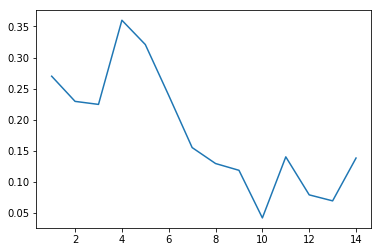

In [37]:
from sklearn.metrics import silhouette_score
import seaborn as sns
sil = []
kmax = 15

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans_k_det = KMeans(n_clusters = k, random_state=0).fit(toronto_grouped_clustering)
  labels = kmeans_k_det.labels_
  sil.append(silhouette_score(toronto_grouped_clustering, labels, metric = 'euclidean'))
x= range(1,15)
sns.lineplot(x,sil)

We can see that the best value of k is 4, as it produces the highest silhoutte score.

In [28]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 2, 0, 0, 1, 0, 0, 0, 0], dtype=int32)

In [29]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = neigh_latlng

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

toronto_merged # check the last columns!

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.8115,-79.1955,0.0,Zoo Exhibit,Food & Drink Shop,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Farm
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.7857,-79.1587,0.0,Bar,Yoga Studio,Dumpling Restaurant,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.7658,-79.1752,3.0,Construction & Landscaping,Gym / Fitness Center,Park,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Donut Shop
3,M1G,Scarborough,Woburn,43.7684,-79.2176,0.0,Park,Korean Restaurant,Coffee Shop,Business Service,Farm,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Yoga Studio
4,M1H,Scarborough,Cedarbrae,43.7697,-79.2394,0.0,Playground,Trail,Farm,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Donut Shop
5,M1J,Scarborough,Scarborough Village,43.7431,-79.2317,0.0,Train Station,Restaurant,Indian Restaurant,Grocery Store,Yoga Studio,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.7263,-79.2636,0.0,Chinese Restaurant,Coffee Shop,Discount Store,Department Store,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.7131,-79.2851,0.0,Bus Line,Intersection,Coffee Shop,Soccer Field,Bus Station,Metro Station,Bakery,Yoga Studio,Ethiopian Restaurant,Event Space
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.7242,-79.2279,0.0,Bank,Liquor Store,Discount Store,Bistro,Coffee Shop,Sandwich Place,Pharmacy,Fish & Chips Shop,Field,Fast Food Restaurant
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.6968,-79.26,0.0,Park,General Entertainment,College Stadium,Gym Pool,Gym,Skating Rink,Yoga Studio,Dumpling Restaurant,Eastern European Restaurant,Electronics Store


As it turns out, all of the postcodes did not return data. For this exercise, dropping the rows is the best way to deal with missing data.

In [30]:
toronto_merged=toronto_merged.dropna()

In [31]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

We can now take a look at how the clusters appear on a map.

In [32]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Finally - we can take a closer look at what each postcode had in common to drive the clustering.

For example - label '3' appears to contain mainy parks, fields, and farms.

In [33]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Rouge, Malvern",0.0,Zoo Exhibit,Food & Drink Shop,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Farm
1,"Highland Creek, Rouge Hill, Port Union",0.0,Bar,Yoga Studio,Dumpling Restaurant,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market
3,Woburn,0.0,Park,Korean Restaurant,Coffee Shop,Business Service,Farm,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Yoga Studio
4,Cedarbrae,0.0,Playground,Trail,Farm,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Donut Shop
5,Scarborough Village,0.0,Train Station,Restaurant,Indian Restaurant,Grocery Store,Yoga Studio,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant
6,"East Birchmount Park, Ionview, Kennedy Park",0.0,Chinese Restaurant,Coffee Shop,Discount Store,Department Store,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market
7,"Clairlea, Golden Mile, Oakridge",0.0,Bus Line,Intersection,Coffee Shop,Soccer Field,Bus Station,Metro Station,Bakery,Yoga Studio,Ethiopian Restaurant,Event Space
8,"Cliffcrest, Cliffside, Scarborough Village West",0.0,Bank,Liquor Store,Discount Store,Bistro,Coffee Shop,Sandwich Place,Pharmacy,Fish & Chips Shop,Field,Fast Food Restaurant
9,"Birch Cliff, Cliffside West",0.0,Park,General Entertainment,College Stadium,Gym Pool,Gym,Skating Rink,Yoga Studio,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
10,"Dorset Park, Scarborough Town Centre, Wexford ...",0.0,Bakery,Gift Shop,Farm,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Yoga Studio


In [34]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,"Bathurst Manor, Downsview North, Wilson Heights",1.0,Men's Store,Yoga Studio,Dumpling Restaurant,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market


In [35]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,"Agincourt North, L'Amoreaux East, Milliken, St...",2.0,Pharmacy,Yoga Studio,Farmers Market,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Fast Food Restaurant


In [36]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"Guildwood, Morningside, West Hill",3.0,Construction & Landscaping,Gym / Fitness Center,Park,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Donut Shop
25,Parkwoods,3.0,Construction & Landscaping,Park,Food & Drink Shop,Historic Site,Dog Run,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market
34,Victoria Village,3.0,Grocery Store,Park,Yoga Studio,Falafel Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Farm,Donut Shop
41,"The Danforth West, Riverdale",3.0,Ice Cream Shop,Park,Discount Store,Bus Line,Grocery Store,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm
46,North Toronto West,3.0,Playground,Garden,Gym Pool,Park,Event Space,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant
50,Rosedale,3.0,Playground,Grocery Store,Candy Store,Park,Gym / Fitness Center,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant
59,"Harbourfront East, Toronto Islands, Union Station",3.0,Pier,Harbor / Marina,Park,Yoga Studio,Falafel Restaurant,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space
64,"Forest Hill North, Forest Hill West",3.0,Park,Restaurant,Yoga Studio,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Donut Shop
73,Humewood-Cedarvale,3.0,Hockey Arena,Field,Grocery Store,Trail,Park,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Donut Shop
79,"Downsview, North Park, Upwood Park",3.0,Park,Bakery,Basketball Court,Flea Market,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Dumpling Restaurant
